In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:44506' processes=10 threads=180, memory=465.66 GiB>

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [4]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [7]:
cfg_var_DpCO2=CESM2_config()
cfg_var_DpCO2.year_s=1960
cfg_var_DpCO2.year_e=2020
cfg_var_DpCO2.setvar('DpCO2')
# cfg_var_DpCO2.list()

cfg_var_DpCO2_ALT_CO2=CESM2_config()
cfg_var_DpCO2_ALT_CO2.year_s=1960
cfg_var_DpCO2_ALT_CO2.year_e=2020
cfg_var_DpCO2_ALT_CO2.setvar('DpCO2_ALT_CO2')

cfg_var_FG_CO2=CESM2_config()
cfg_var_FG_CO2.year_s=1960
cfg_var_FG_CO2.year_e=2020
cfg_var_FG_CO2.setvar('FG_CO2')

cfg_var_FG_ALT_CO2=CESM2_config()
cfg_var_FG_ALT_CO2.year_s=1960
cfg_var_FG_ALT_CO2.year_e=2020
cfg_var_FG_ALT_CO2.setvar('FG_ALT_CO2')

if cfg_var_DpCO2.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# Read files

In [6]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DpCO2.var, cfg_var_DpCO2_ALT_CO2.var, cfg_var_FG_CO2.var, cfg_var_FG_ALT_CO2.var]
def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','lon','lat', 'TLONG', 'TLAT', 'dco2']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_DpCO2.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_DpCO2.year_e+1, 1, 1)

In [7]:
# Read LE dataset

start_time = time.time()


cfg_var_DpCO2.LE_path_load(cfg_var_DpCO2.var)
cfg_var_DpCO2.LE_ds = xr.open_mfdataset(cfg_var_DpCO2.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DpCO2.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_DpCO2.LE_ds = cfg_var_DpCO2.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DpCO2.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DpCO2.LE_ds.time))
cfg_var_DpCO2.LE_ds = cfg_var_DpCO2.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 98.71084690093994


In [9]:
# Read ODA dataset (projd only)

start_time = time.time()

cfg_var_DpCO2.ODA_path_load(cfg_var_DpCO2.var)

cfg_var_DpCO2.ODA_ds = xr.open_mfdataset(cfg_var_DpCO2.ODA_file_list[0][10:20], 
                           chunks={'time': 2}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_DpCO2.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

cfg_var_DpCO2.ODA_ds = cfg_var_DpCO2.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_DpCO2.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DpCO2.ODA_ds.time))
cfg_var_DpCO2.ODA_ds = cfg_var_DpCO2.ODA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 33.806912899017334


In [10]:
#Read ADA dataset
start_time = time.time()

cfg_var_DpCO2.ADA_path_load(cfg_var_DpCO2.var)
cfg_var_DpCO2.ADA_ds = xr.open_mfdataset(cfg_var_DpCO2.ADA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DpCO2.ADA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_DpCO2.ADA_ds = cfg_var_DpCO2.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DpCO2.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DpCO2.ADA_ds.time))
cfg_var_DpCO2.ADA_ds = cfg_var_DpCO2.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

elasped time for reading ADA: 32.970654249191284


In [11]:
# Read Observation dataset
start_time = time.time()

cfg_var_DpCO2.OBS_path_load(cfg_var_DpCO2.var)
# cfg_var_DpCO2.OBS_ds = xr.open_mfdataset(cfg_var_DpCO2.OBS_file_list[0][0], 
#                        combine='nested',
#                        concat_dim= 'time',
#                        chunks={'time': 6}, 
#                        parallel=True,
#                        preprocess=lambda ds: process_coords(ds, start_date, end_date),
#                        decode_cf=True, 
#                        decode_times=True,
#                        engine='h5netcdf')
# cfg_var_DpCO2.OBS_ds = xr.open_mfdataset(cfg_var_DpCO2.OBS_file_list[0][0], 
#                        chunks={'time': 12}, 
#                        parallel=True,
#                        preprocess=lambda ds: process_coords_obs(ds),
#                        decode_cf=True, 
#                        decode_times=True,)
cfg_var_DpCO2.OBS_ds = xr.open_mfdataset(cfg_var_DpCO2.OBS_file_list[0][0], 
                       chunks={'time': 12}, 
                       parallel=True,
                       preprocess=lambda ds: process_coords_obs(ds),
                       decode_cf=True,)

cfg_var_DpCO2.OBS_ds = cfg_var_DpCO2.OBS_ds.rename({cfg_var_DpCO2.OBS_var: cfg_var_DpCO2.var})

# new_time = cfg_var_DpCO2.OBS_ds.time + np.array([datetime.timedelta(days=15)] * len(cfg_var_DpCO2.OBS_ds.time))
# cfg_var_DpCO2.OBS_ds = cfg_var_DpCO2.OBS_ds.assign_coords(time=new_time)

if cfg_var_DpCO2.var=='SSH':
    cfg_var_DpCO2.OBS_ds=cfg_var_DpCO2.OBS_ds.assign_coords(time=cfg_var_DpCO2.ODA_ds.time[396:732]) #1993~2020
elif cfg_var_DpCO2.var=='photoC_TOT_zint_100m':
    cfg_var_DpCO2.OBS_ds=cfg_var_DpCO2.OBS_ds.assign_coords(time=cfg_var_DpCO2.ODA_ds.time[456:732]) #1999~2020
elif cfg_var_DpCO2.var=='FG_CO2':
    cfg_var_DpCO2.OBS_ds=cfg_var_DpCO2.OBS_ds.assign_coords(time=cfg_var_DpCO2.ODA_ds.time[264:732])
elif cfg_var_DpCO2.var=='DpCO2_ALT_CO2':
    cfg_var_DpCO2.OBS_ds=cfg_var_DpCO2.OBS_ds.assign_coords(time=cfg_var_DpCO2.ODA_ds.time[264:732])
elif cfg_var_DpCO2.var=='DpCO2':
    cfg_var_DpCO2.OBS_ds=cfg_var_DpCO2.OBS_ds.assign_coords(time=cfg_var_DpCO2.ODA_ds.time[264:732]) #1982~2020
cfg_var_DpCO2.OBS_ds.time

# global mean removal for SSH
if cfg_var_DpCO2.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var_DpCO2.OBS_ds[cfg_var_DpCO2.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    # 필터링된 지역에 대해 global mean 계산
    cfg_var_DpCO2.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
    # 원 데이터에서 global mean을 제거한 값
    cfg_var_DpCO2.OBS_ds['SSH'] = cfg_var_DpCO2.OBS_ds[cfg_var_DpCO2.var] - cfg_var_DpCO2.OBS_ds['gm']


# Step 1: 결측값이 아닌 값의 비율 계산
# 결측값이 아닌 값들에 대해 True, 결측값에 대해 False로 표시
valid_data_count = (~cfg_var_DpCO2.OBS_ds[cfg_var_DpCO2.var].isnull()).sum(dim='time')
# Step 2: 전체 시간 축의 길이 (즉, 데이터가 있어야 할 총 시간 개수)
total_time_steps = cfg_var_DpCO2.OBS_ds['time'].size
# Step 3: 80% 이상의 값이 있는지 계산
# 비율 계산 후, 80% 이상이면 True, 그렇지 않으면 False로 표시
threshold = 0.8
mask = (valid_data_count / total_time_steps) >= threshold
# Step 4: 마스크 변수를 데이터셋에 추가
cfg_var_DpCO2.OBS_ds['mask_80_percent'] = mask
cfg_var_DpCO2.OBS_ds['mask_80_percent'].compute()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

elasped time for reading OBS: 54.03689670562744


# Take annual means

In [12]:
# obs_non_nan_times = cfg_var_DpCO2.OBS_ds.notnull()
# ada_filtered = cfg_var_DpCO2.ADA_ds.sel(time=obs_non_nan_times)

# Step 1: OBS_ds에서 NaN이 아닌 시간대에 해당하는 boolean mask 생성
obs_non_nan_times = cfg_var_DpCO2.OBS_ds[cfg_var_DpCO2.var].notnull().any(dim=['nlat', 'nlon'])
# Step 2: boolean mask를 명시적으로 계산 (compute() 호출)
obs_non_nan_times = obs_non_nan_times.compute()
# Step 3: NaN이 아닌 시간대에 해당하는 time 좌표 추출
non_nan_time_coords = cfg_var_DpCO2.OBS_ds.time.where(obs_non_nan_times, drop=True)
# Step 4: ADA_ds에서 NaN이 아닌 시간대에 해당하는 자료만 선택
oda_filtered = cfg_var_DpCO2.ODA_ds.sel(time=non_nan_time_coords)
le_filtered = cfg_var_DpCO2.LE_ds.sel(time=non_nan_time_coords)
ada_filtered = cfg_var_DpCO2.ADA_ds.sel(time=non_nan_time_coords)

# Step 5: 연도별로 그룹화하고 NaN을 무시한 연평균 계산
ada_annual_mean = ada_filtered.groupby('time.year').mean(dim='time', skipna=True)
oda_annual_mean = oda_filtered.groupby('time.year').mean(dim='time', skipna=True)
le_annual_mean = le_filtered.groupby('time.year').mean(dim='time', skipna=True)
obs_annual_mean = cfg_var_DpCO2.OBS_ds.groupby('time.year').mean(dim='time', skipna=True)

oda_full_annual_mean = cfg_var_DpCO2.ODA_ds.groupby('time.year').mean(dim='time', skipna=True)
le_full_annual_mean = cfg_var_DpCO2.LE_ds.groupby('time.year').mean(dim='time', skipna=True)
ada_full_annual_mean = cfg_var_DpCO2.ADA_ds.groupby('time.year').mean(dim='time', skipna=True)

ref_time=cfg_var_DpCO2.ODA_ds.time.groupby('time.year').mean(dim='time')

In [13]:
# take ensemble mean, increments (ODA-LE, ADA-ODA)

ada_annual_mean['enm']=ada_annual_mean[cfg_var_DpCO2.var].mean(dim='ens_ADA')
oda_annual_mean['enm']=oda_annual_mean[cfg_var_DpCO2.var].mean(dim='ens_ODA')
le_annual_mean['enm']=le_annual_mean[cfg_var_DpCO2.var].mean(dim='ens_LE')

oda_annual_mean['diff_le']=oda_annual_mean[cfg_var_DpCO2.var] - le_annual_mean.enm
ada_annual_mean['diff_oda']=ada_annual_mean[cfg_var_DpCO2.var] - oda_annual_mean.enm

In [15]:
# plot for ADA

def pop_add_cyclic(da):
        #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
        #This doesn't work with Dask (DA should be loaded)
        #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
        #Output is DA
        nj = da.TLAT.shape[0]
        ni = da.TLONG.shape[1]
        xL = int(ni/2 - 1)
        xR = int(xL + ni)
        tlon = da.TLONG.data
        tlat = da.TLAT.data
        tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
        lon  = np.concatenate((tlon, tlon + 360.), 1)
        lon = lon[:, xL:xR]
        if ni == 320:
            lon[367:-3, 0] = lon[367:-3, 0] + 360.
        lon = lon - 360.
        lon = np.hstack((lon, lon[:, 0:1] + 360.))
        if ni == 320:
            lon[367:, -1] = lon[367:, -1] - 360.
        #-- trick cartopy into doing the right thing:
        #   it gets confused when the cyclic coords are identical
        lon[:, 0] = lon[:, 0] - 1e-8
        #-- periodicity
        lat = np.concatenate((tlat, tlat), 1)
        lat = lat[:, xL:xR]
        lat = np.hstack((lat, lat[:,0:1]))
        TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
        TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
        # copy vars
        v = da.name
        v_dims = da.dims
        # determine and sort other dimensions
        other_dims = set(v_dims) - {'nlat', 'nlon'}
        other_dims = tuple([d for d in v_dims if d in other_dims])
        lon_dim = da.dims.index('nlon')
        field = da.data
        field = np.concatenate((field, field), lon_dim)
        field = field[:, xL:xR]
        field = np.concatenate((field, field[:, 0:1]), lon_dim)
        dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
        dao = dao.assign_coords(TLONG=TLONG)
        dao = dao.assign_coords(TLAT=TLAT)
        return dao

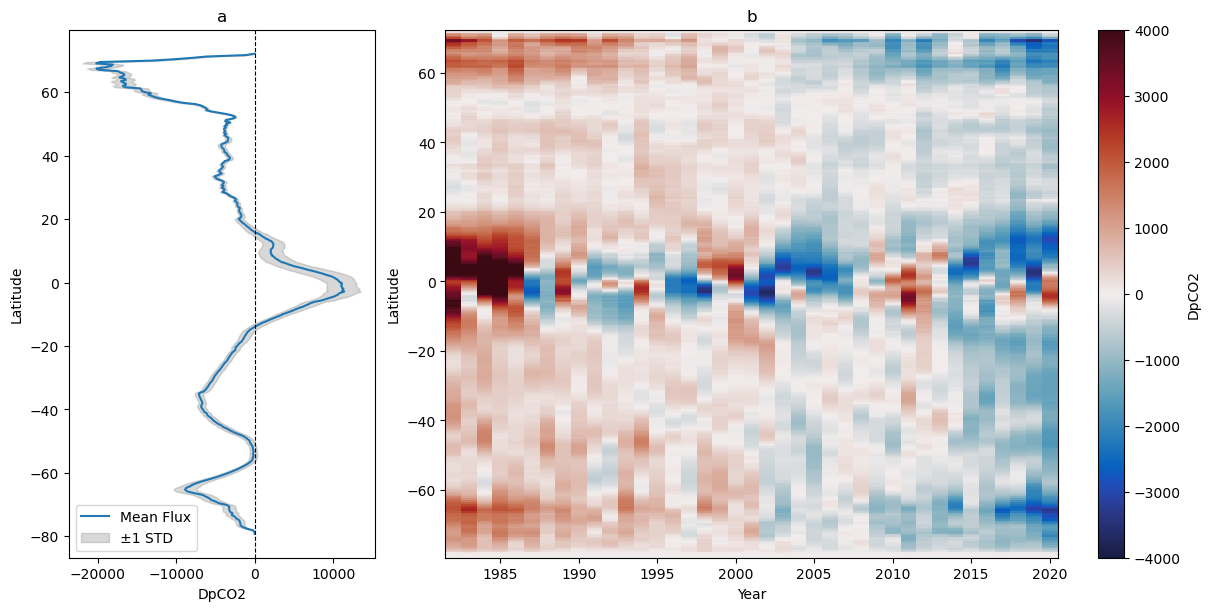

In [16]:
# Zonal Integration (Calculate the zonal mean)
zonal_sum = ada_annual_mean['enm'].sum(dim='nlon')
# zonal_sum['TLONG']=ds_grid.TLONG
# zonal_sum['TLAT']=ds_grid.TLAT

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 2]}, constrained_layout=True)

# Left: Latitude vs Value Plot
lat_mean = zonal_sum.mean(dim='year')
lat_std = zonal_sum.std(dim='year')

axes[0].plot(lat_mean, ds_grid.TLAT[:, 0], label='Mean Flux')
axes[0].fill_betweenx(
    ds_grid.TLAT[:, 0],
    lat_mean - lat_std,
    lat_mean + lat_std,
    color='gray',
    alpha=0.3,
    label='±1 STD'
)
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_xlabel('DpCO2')
axes[0].set_ylabel('Latitude')
axes[0].set_title('a')
axes[0].legend()

# Right: Hovmöller Diagram
time = zonal_sum.year
latitude = ds_grid.TLAT[:, 0]
pcm = axes[1].pcolormesh(
    time, latitude, zonal_sum.T-lat_mean, cmap=cmocean.cm.balance, shading='auto', vmin=-4000, vmax=4000)
cbar = fig.colorbar(pcm, ax=axes[1], orientation='vertical', label='DpCO2')
axes[1].set_title('b')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Latitude')

plt.show()


In [17]:
zonal_sum

<xarray.DataArray 'enm' (year: 39, nlat: 384)>
dask.array<sum-aggregate, shape=(39, 384), dtype=float32, chunksize=(1, 384), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1982 1983 1984 1985 1986 ... 2016 2017 2018 2019 2020
Dimensions without coordinates: nlat

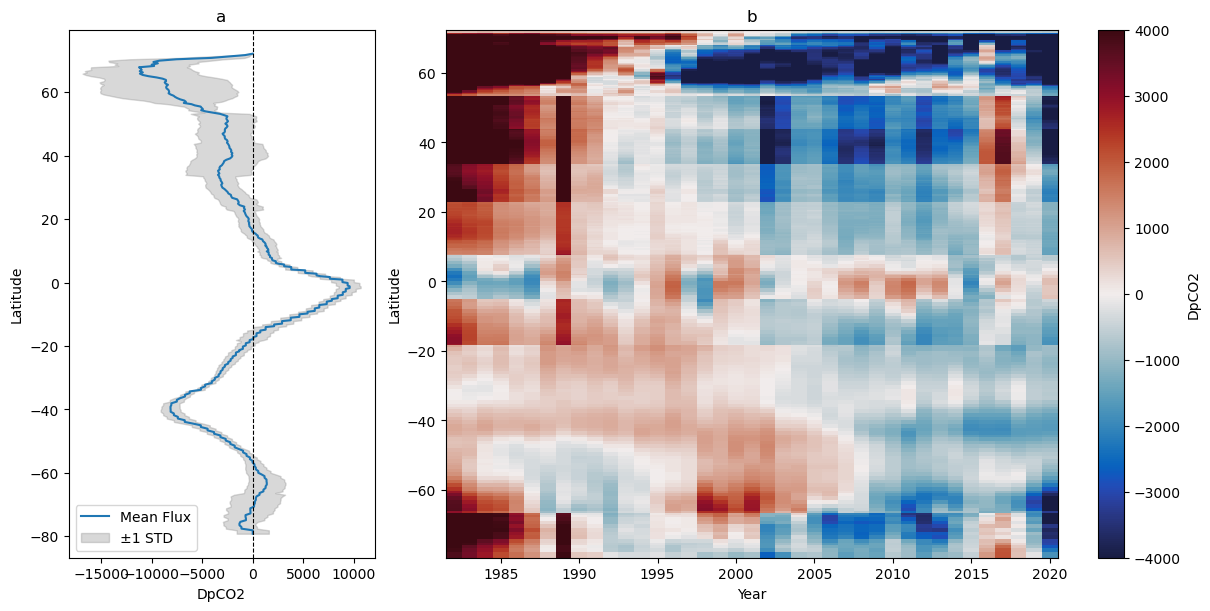

In [20]:
# Zonal Integration (Calculate the zonal mean)
zonal_sum = obs_annual_mean['DpCO2'].sum(dim='nlon')
# zonal_sum['TLONG']=ds_grid.TLONG
# zonal_sum['TLAT']=ds_grid.TLAT

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 2]}, constrained_layout=True)

# Left: Latitude vs Value Plot
lat_mean = zonal_sum.mean(dim='year')
lat_std = zonal_sum.std(dim='year')

axes[0].plot(lat_mean, ds_grid.TLAT[:, 0], label='Mean Flux')
axes[0].fill_betweenx(
    ds_grid.TLAT[:, 0],
    lat_mean - lat_std,
    lat_mean + lat_std,
    color='gray',
    alpha=0.3,
    label='±1 STD'
)
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_xlabel('DpCO2')
axes[0].set_ylabel('Latitude')
axes[0].set_title('a')
axes[0].legend()

# Right: Hovmöller Diagram
time = zonal_sum.year
latitude = ds_grid.TLAT[:, 0]
pcm = axes[1].pcolormesh(
    time, latitude, zonal_sum.T-lat_mean, cmap=cmocean.cm.balance, shading='auto', vmin=-4000, vmax=4000)
cbar = fig.colorbar(pcm, ax=axes[1], orientation='vertical', label='DpCO2')
axes[1].set_title('b')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Latitude')

plt.show()
